📊 Dataset Shape: (1000, 6)
🔹 Columns: ['logins_per_week', 'time_spent_hours', 'support_tickets', 'subscription_plan', 'payment_history', 'churn']
   logins_per_week  time_spent_hours  support_tickets subscription_plan  \
0                6          3.785487                9        Enterprise   
1               19          6.813108                6        Enterprise   
2               28          2.024475                6        Enterprise   
3               14         14.315360                7        Enterprise   
4               10          9.132002                0             Basic   

  payment_history  churn  
0         Default      0  
1            Late      1  
2         On-time      1  
3         Default      0  
4         Default      0  

🔎 Binary column candidates found: ['churn']
✅ Selected target column: 'churn'

🔹 Evaluating RandomForest...

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       1

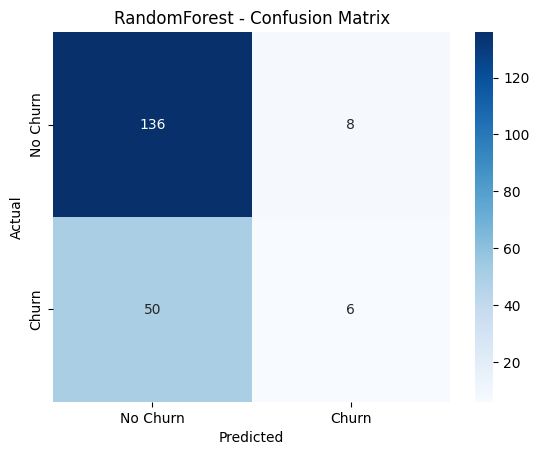

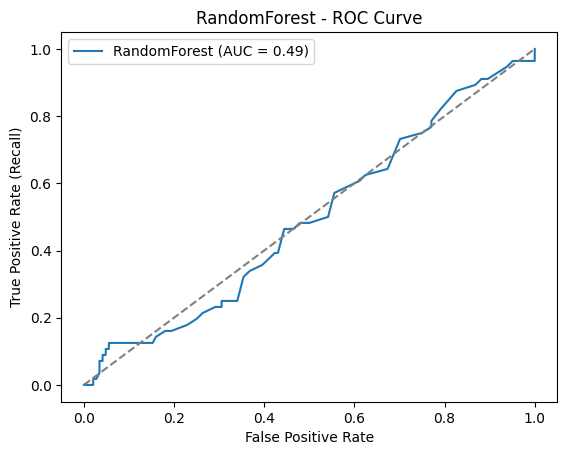


🔹 Evaluating LogisticRegression...

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.51      0.59       144
           1       0.28      0.48      0.35        56

    accuracy                           0.50       200
   macro avg       0.50      0.49      0.47       200
weighted avg       0.59      0.50      0.53       200



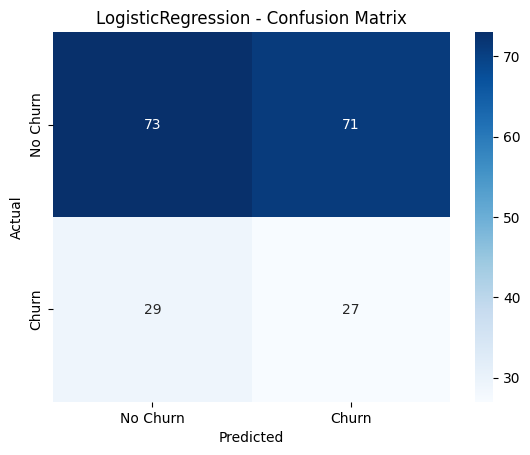

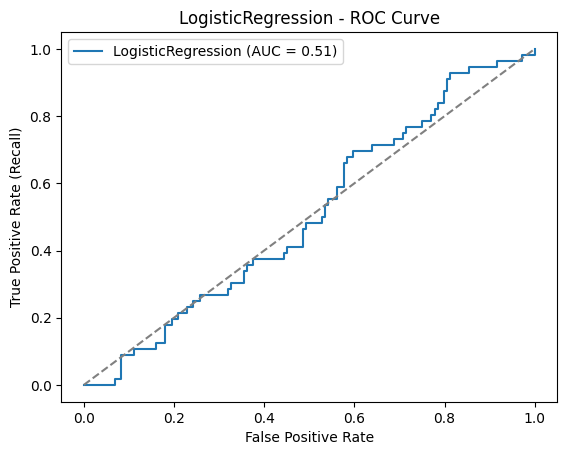


📌 Cross-Validation Summary:

Model: RandomForest
Accuracy: 0.6920 ± 0.0172
Precision: 0.3093 ± 0.0904
Recall: 0.0864 ± 0.0257
F1: 0.1344 ± 0.0391
AUC: 0.4993 ± 0.0261

Model: LogisticRegression
Accuracy: 0.5280 ± 0.0254
Precision: 0.2937 ± 0.0163
Recall: 0.4983 ± 0.0175
F1: 0.3694 ± 0.0162
AUC: 0.5161 ± 0.0319


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Load your dataset
# -------------------------
df = pd.read_csv("/content/drive/MyDrive/saas_churn_data.csv")   # change file name

print(f"📊 Dataset Shape: {df.shape}")
print(f"🔹 Columns: {list(df.columns)}")
print(df.head())

# -------------------------
# Auto-detect target column (binary)
# -------------------------
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
print(f"\n🔎 Binary column candidates found: {binary_cols}")
target_col = binary_cols[0] if binary_cols else df.columns[-1]
print(f"✅ Selected target column: '{target_col}'")

X = df.drop(columns=[target_col])
y = df[target_col]

# Encode categorical features
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Standardize numeric features
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# -------------------------
# Models for comparison
# -------------------------
models = {
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
}

# -------------------------
# Stratified K-Fold Cross Validation
# -------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    print(f"\n🔹 Evaluating {name}...")
    acc_scores, prec_scores, rec_scores, f1_scores, auc_scores = [], [], [], [], []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:,1]

        # Metrics
        acc_scores.append(accuracy_score(y_test, y_pred))
        prec_scores.append(precision_score(y_test, y_pred))
        rec_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

        # ROC-AUC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_scores.append(auc(fpr, tpr))

    results[name] = {
        "Accuracy": (np.mean(acc_scores), np.std(acc_scores)),
        "Precision": (np.mean(prec_scores), np.std(prec_scores)),
        "Recall": (np.mean(rec_scores), np.std(rec_scores)),
        "F1": (np.mean(f1_scores), np.std(f1_scores)),
        "AUC": (np.mean(auc_scores), np.std(auc_scores))
    }

    # Print classification report (last fold)
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"{name} - ROC Curve")
    plt.legend()
    plt.show()

# -------------------------
# Final Results Summary
# -------------------------
print("\n📌 Cross-Validation Summary:")
for model, metrics in results.items():
    print(f"\nModel: {model}")
    for m, (mean, std) in metrics.items():
        print(f"{m}: {mean:.4f} ± {std:.4f}")
